# 1.0 Import Library and File

In [1]:
!pip install scikit-learn --upgrade

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import PowerTransformer, StandardScaler, OneHotEncoder, OrdinalEncoder
from scipy.stats import skew, zscore

In [2]:
heartAssign = pd.read_csv("/content/sample_data/HeartAssign2.csv")

# 2.0 Data Exploration

## Data overview

In [3]:
categorical_cols = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]
numerical_cols = ["age", "trestbps", "chol", "thalach", "oldpeak"]
target_column = "target"

In [4]:
print("The first 5 rows of the dataset:")
heartAssign.head()

The first 5 rows of the dataset:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52.0001,1,0,125,212.0,0.0,1.0,168.0,0,1.0,2,2,3,0.0
1,53.0002,1,0,140,203.0,1.0,0.0,155.0,1,3.1,0,0,3,0.0
2,70.0003,1,0,145,174.0,0.0,1.0,125.0,1,2.6,0,0,3,0.0
3,61.0004,1,0,148,203.0,0.0,1.0,161.0,0,0.0,2,1,3,0.0
4,62.0005,0,0,138,294.0,1.0,1.0,106.0,0,1.9,1,3,2,0.0


In [5]:
print("The data frame of the dataset: ")
heartAssign.info()

The data frame of the dataset: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1027 entries, 0 to 1026
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   float64
 1   sex       1027 non-null   int64  
 2   cp        1027 non-null   int64  
 3   trestbps  1027 non-null   int64  
 4   chol      1026 non-null   float64
 5   fbs       1026 non-null   float64
 6   restecg   1026 non-null   float64
 7   thalach   1026 non-null   float64
 8   exang     1027 non-null   int64  
 9   oldpeak   1026 non-null   float64
 10  slope     1027 non-null   int64  
 11  ca        1027 non-null   int64  
 12  thal      1027 non-null   int64  
 13  target    1025 non-null   float64
dtypes: float64(7), int64(7)
memory usage: 112.5 KB


In [6]:
print("Rows: ", heartAssign.shape[0])
print("Columns: ", heartAssign.shape[1])

Rows:  1027
Columns:  14


In [7]:
print("Number of duplicates: ", heartAssign.duplicated().sum())

Number of duplicates:  10


In [8]:
print("Number of missing values: ", heartAssign.isna().sum().sum())

Number of missing values:  9


In [9]:
# Overview of the statistical information of numerical features
print("Summary of Numerical Features:\n")
print(heartAssign[numerical_cols].describe())

Summary of Numerical Features:

               age     trestbps         chol      thalach      oldpeak
count  1025.000000  1027.000000  1026.000000  1026.000000  1026.000000
mean     54.468657   132.247322   245.877193   149.798246     1.107797
std       9.075495    27.240879    51.514152    29.624565     1.781657
min      29.000000    94.000000   126.000000    71.000000     0.000000
25%      48.000000   120.000000   211.000000   132.000000     0.000000
50%      56.017100   130.000000   240.000000   152.000000     0.800000
75%      61.052100   140.000000   275.000000   166.000000     1.800000
max      77.038500   800.000000   564.000000   746.000000    44.000000


## Data visualization

### Univariate Analysis

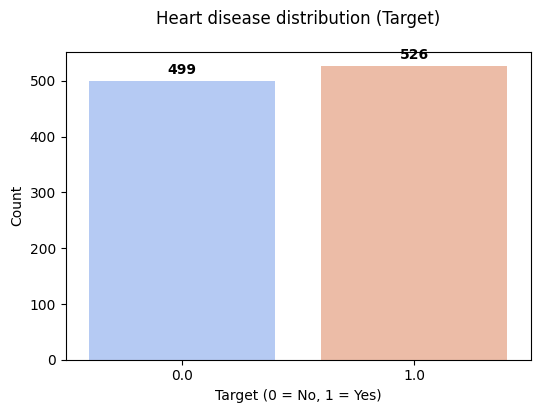

In [10]:
# Check frequency of TARGET
plt.figure(figsize=(6, 4))
ax = sns.countplot(x="target", data=heartAssign, palette="coolwarm")
for container in ax.containers:
  ax.bar_label(container, fmt="%d", label_type="edge", padding=3, fontsize=10, color="black", weight="bold")
plt.title("Heart disease distribution (Target)", pad=20)
plt.xlabel("Target (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

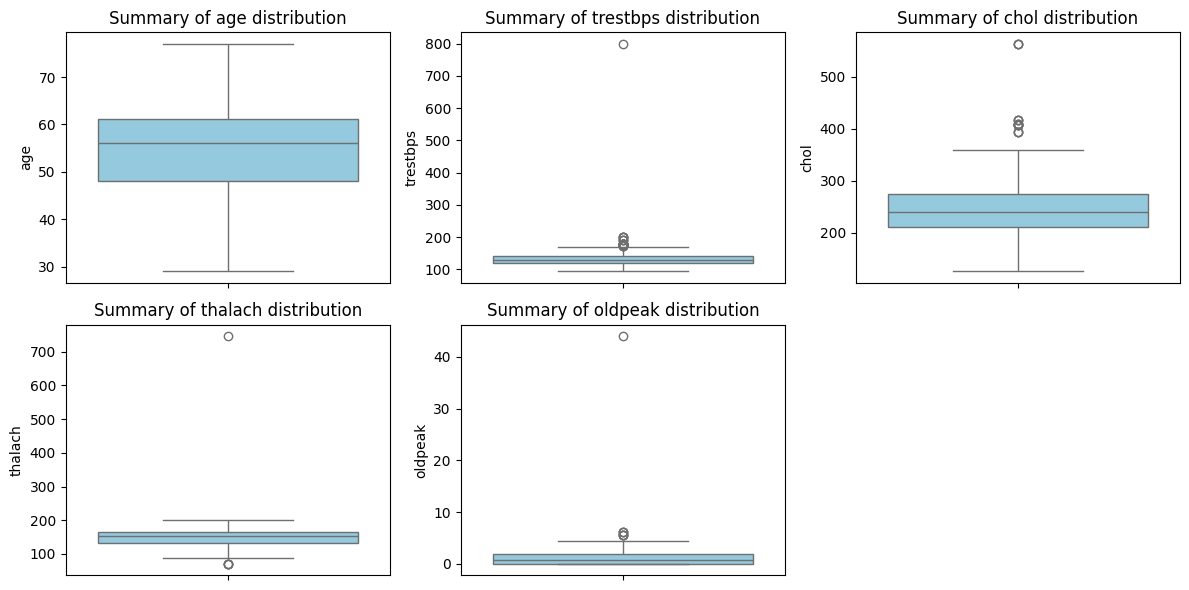

In [11]:
plt.figure(figsize=(12, 6))

for i, feature in enumerate(numerical_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=heartAssign[feature], color="skyblue")
    plt.title(f"Summary of {feature} distribution")

plt.tight_layout()
plt.show()

In [12]:
# Check for numerical column distribution
def plot_histograms_with_skewness(df, df_name, numerical_cols, ncols=2, figsize_per_row=3):
    """
    Plots histograms for numerical columns with skewness values, with 2 histograms per row.

    Parameters:
    - df: DataFrame containing the numerical columns
    - df_name: Name of the dataset (for printing)
    - numerical_cols: List of numerical column names
    - ncols: Number of columns per row in the plot grid (default=2 for better visibility)
    - figsize_per_row: Height of each row in the figure (default=3 for better compactness)

    Returns:
    - Displays a grid of histogram plots with skewness values.
    """
    # Set number of rows dynamically (2 histograms per row)
    nrows = int(np.ceil(len(numerical_cols) / ncols))

    # Set figure size (fixed width, adaptable height)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, nrows * figsize_per_row))
    axes = axes.flatten()  # Flatten axes array for easier indexing

    # Plot histograms with skewness values
    for i, col in enumerate(numerical_cols):
        sns.histplot(df[col], bins=30, kde=True, ax=axes[i])
        skewness = skew(df[col].dropna())  # Compute skewness, ignoring NaNs
        axes[i].set_title(f"Distribution of {col}\n(Skewness: {skewness:.2f})", fontsize=10)
        axes[i].set_xlabel("")
        axes[i].tick_params(axis='both', labelsize=8)  # Reduce tick label size

    # Remove unused subplots (if any)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    print(f"Histogram of {df_name} with skewness: ")
    plt.tight_layout()
    plt.show()

Histogram of Original Dataset with skewness: 


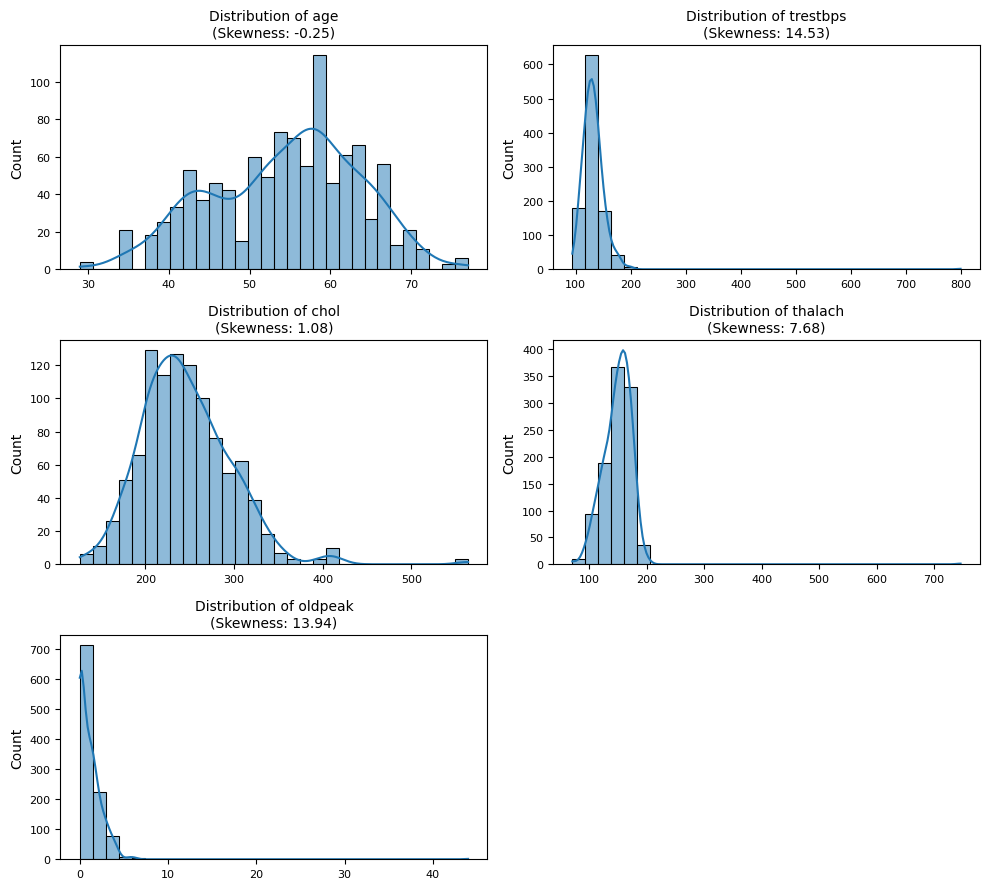

In [13]:
plot_histograms_with_skewness(heartAssign, "Original Dataset", numerical_cols)

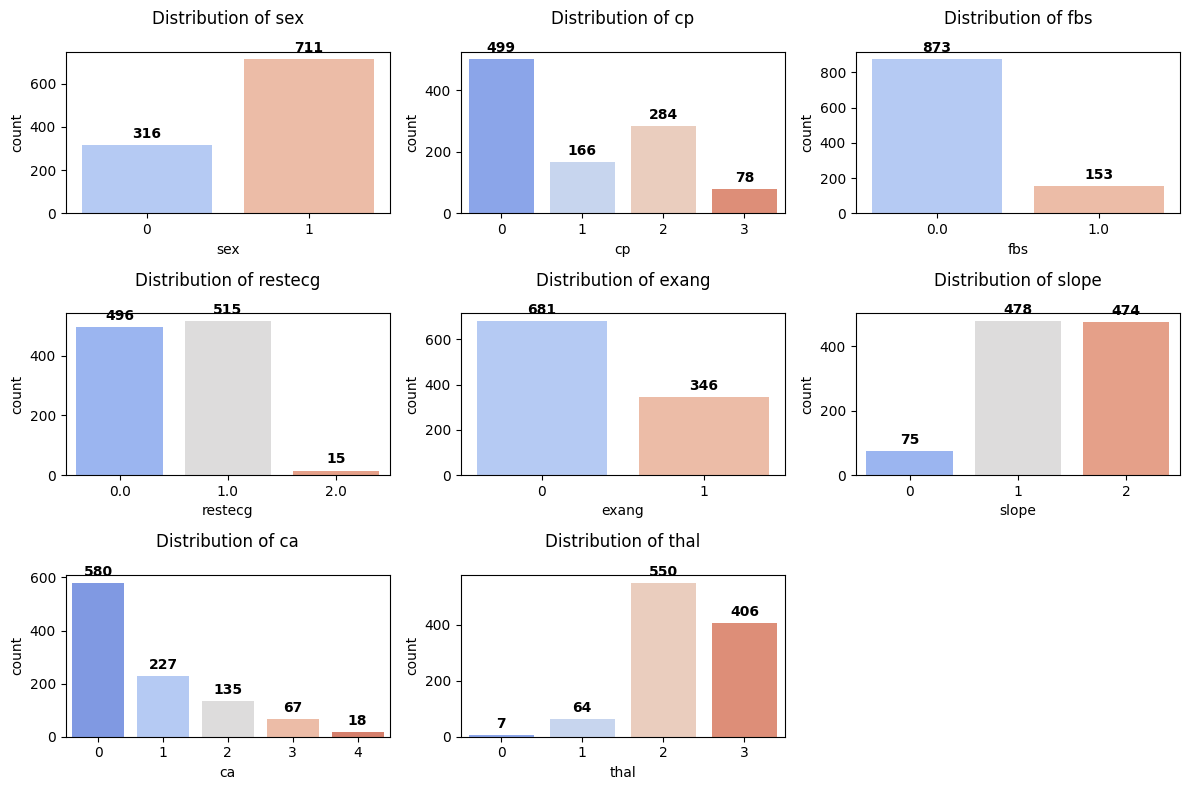

In [14]:
# Check the frequency

plt.figure(figsize=(12, 8))
for i, feature in enumerate(categorical_cols):
    plt.subplot(3, 3, i + 1)
    ax = sns.countplot(x=feature, data=heartAssign, palette="coolwarm")
    for container in ax.containers:
        ax.bar_label(container, fmt="%d", label_type="edge", padding=3,
                     fontsize=10, color="black", weight="bold")
    plt.title(f"Distribution of {feature}", pad=20)

plt.tight_layout()
plt.show()

### Bivariate Analysis

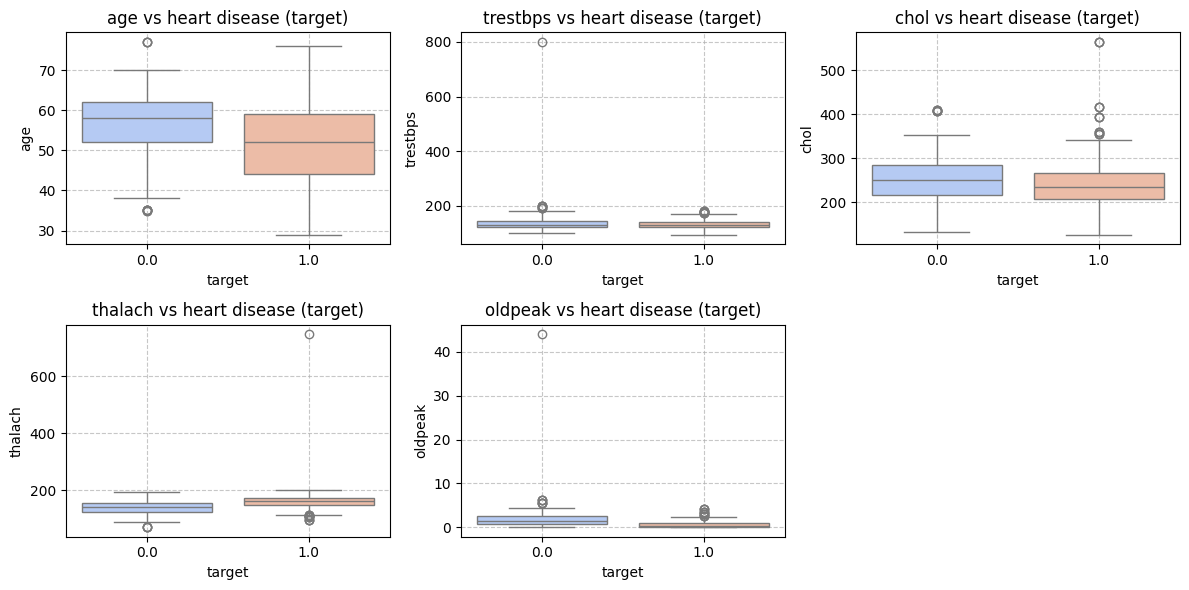

In [15]:
# Numerical features vs TARGET (Boxplots)
plt.figure(figsize=(12, 6))
for i, feature in enumerate(numerical_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x="target", y=heartAssign[feature], data=heartAssign, palette="coolwarm")
    plt.title(f"{feature} vs heart disease (target)")
    plt.grid(True, linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

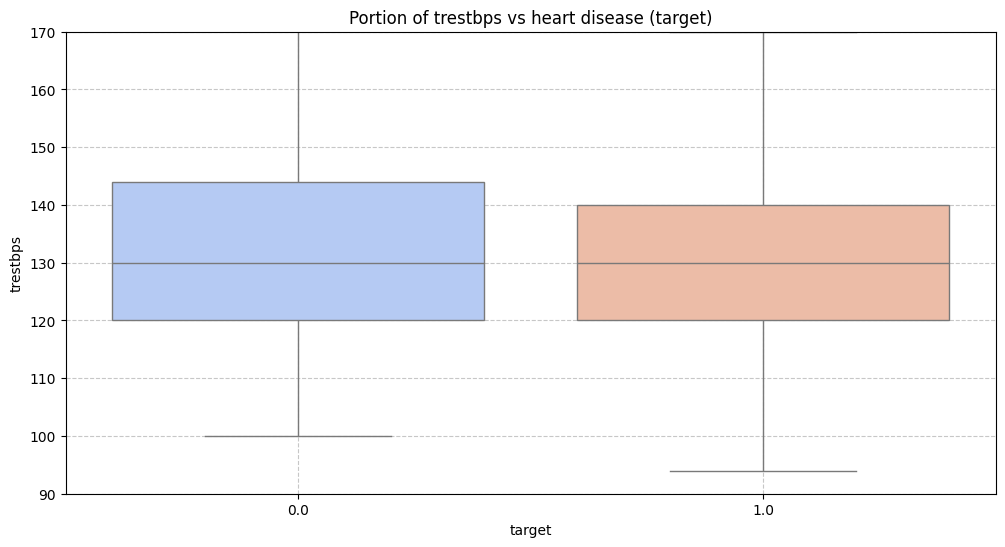

In [16]:
# Numerical features vs TARGET (Boxplots)
plt.figure(figsize=(12, 6))
Q1 = heartAssign['trestbps'].quantile(0.25)
Q3 = heartAssign['trestbps'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
sns.boxplot(x="target", y=heartAssign['trestbps'], data=heartAssign, palette="coolwarm")
plt.ylim(lower_bound, upper_bound)  # Adjust limits to focus on narrow range
plt.title(f"Portion of {'trestbps'} vs heart disease (target)")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

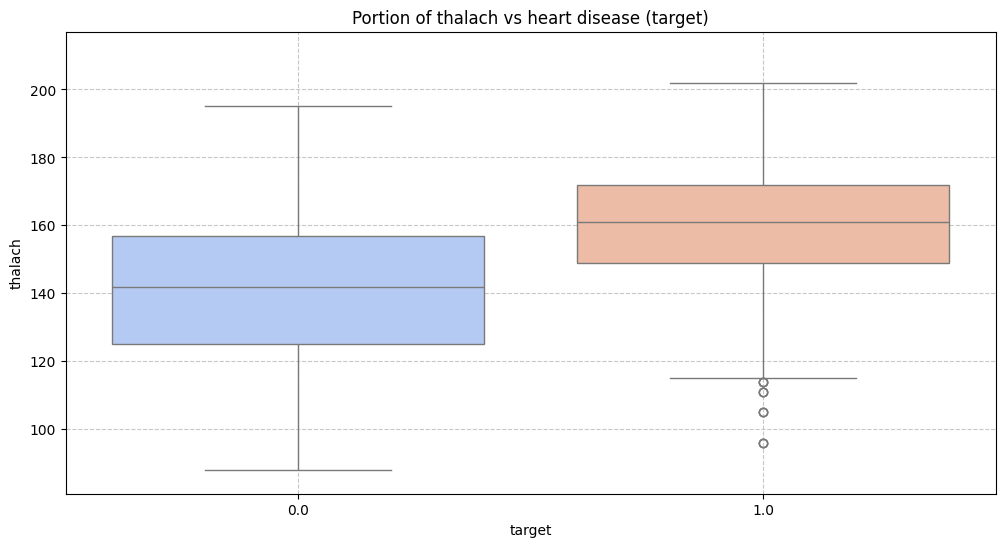

In [17]:
plt.figure(figsize=(12, 6))
Q1 = heartAssign['thalach'].quantile(0.25)
Q3 = heartAssign['thalach'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

sns.boxplot(x="target", y=heartAssign['thalach'], data=heartAssign, palette="coolwarm")
plt.ylim(lower_bound, upper_bound)
plt.title(f"Portion of {'thalach'} vs heart disease (target)")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

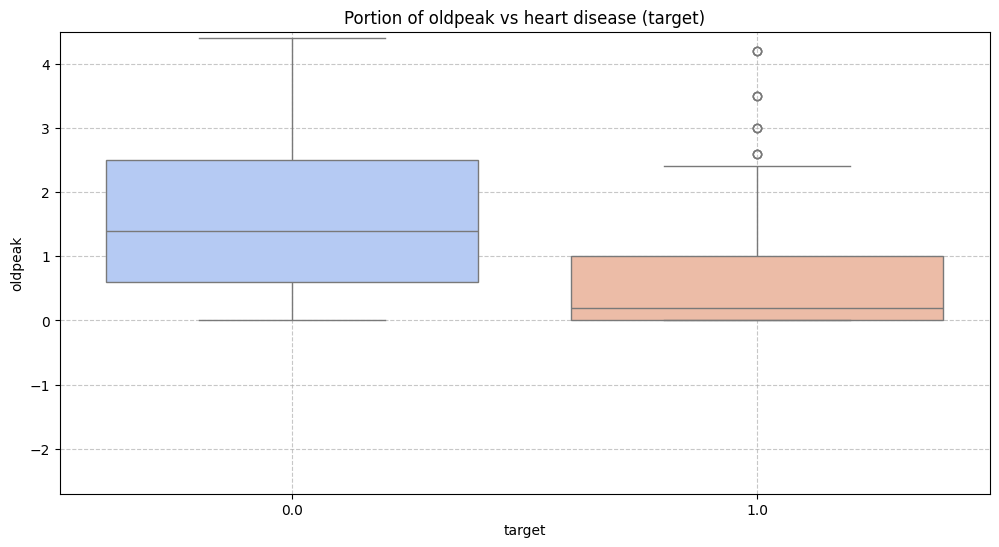

In [18]:
plt.figure(figsize=(12, 6))
Q1 = heartAssign['oldpeak'].quantile(0.25)
Q3 = heartAssign['oldpeak'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

sns.boxplot(x="target", y=heartAssign['oldpeak'], data=heartAssign, palette="coolwarm")
plt.ylim(lower_bound, upper_bound)
plt.title(f"Portion of {'oldpeak'} vs heart disease (target)")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

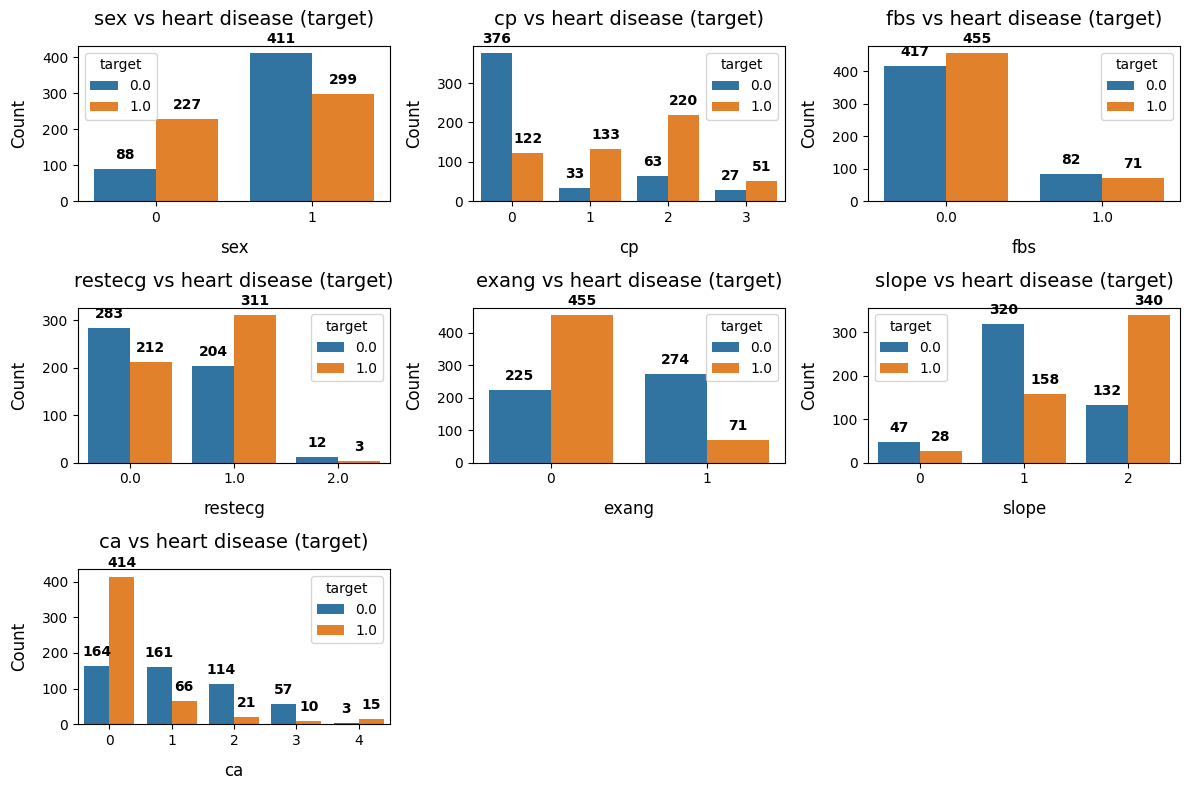

In [19]:
# Categorical vs target (Bar chats)
plt.figure(figsize=(12, 8))

for i, col in enumerate(categorical_cols[:-1]):  # Exclude "target" itself
    plt.subplot(3, 3, i + 1)  # Create subplot grid
    ax = sns.countplot(x=col, hue="target", data=heartAssign)  # Plot countplot

    # Adjust title with custom styling
    plt.title(f"{col} vs heart disease (target)", fontsize=14, pad=15, loc="center")  # Customize title

    # Add data labels on top of bars
    for container in ax.containers:
        ax.bar_label(container,
                     fmt="%d",  # Format as integer
                     label_type="edge",  # Place label at the edge of bar
                     padding=5,  # Increase spacing from bars
                     fontsize=10,  # Adjust font size
                     color="black",  # Set text color
                     weight="bold")  # Make text bold

    # Adjust x-axis and y-axis labels
    ax.set_xlabel(col, fontsize=12, labelpad=10)
    ax.set_ylabel("Count", fontsize=12, labelpad=10)

plt.tight_layout()
plt.show()

### Multivariate Analysis

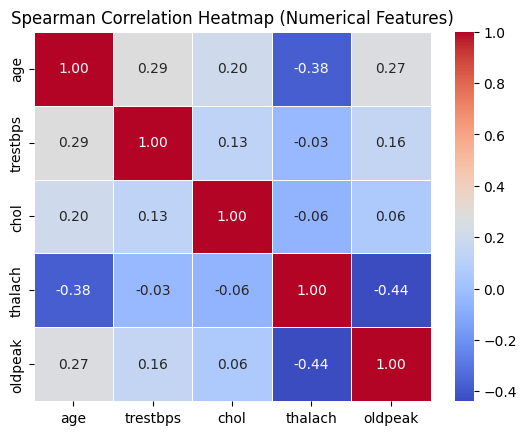

In [20]:
corr_matrix = heartAssign[numerical_cols].corr(method='spearman')

plt.title("Spearman Correlation Heatmap (Numerical Features)")
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.show()

In [21]:
X = heartAssign[numerical_cols]

# Add a constant column for calculation
X = X.assign(constant=1)

# Before calculating VIF, replace inf and NaN values
X = X.replace([np.inf, -np.inf], np.nan).fillna(X.mean())  # Replace inf with NaN, then fill NaN with mean

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Drop the constant row (not needed for interpretation)
vif_data = vif_data[vif_data["Feature"] != "constant"]

print(vif_data)

    Feature       VIF
0       age  1.178117
1  trestbps  1.836627
2      chol  1.057901
3   thalach  1.144282
4   oldpeak  1.850181


# 3.0 Data Splitting

In [22]:
x = heartAssign.drop(target_column, axis=1)
y = heartAssign[target_column]

# Split x and y to get training and testing set
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size= 0.70, random_state=42)

# Split X_test and y_test further to get validation set
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)  # Split test set in half for validation

In [23]:
def save_and_summarize_data(x, y, filename):
    """
    Combines feature and label data, saves it to a CSV file, loads it back,
    and prints a summary of the dataset.

    Parameters:
    x (pd.DataFrame): Feature data.
    y (pd.Series or pd.DataFrame): Label data.
    filename (str): The name of the file to save and load.

    Returns:
    pd.DataFrame: The loaded DataFrame.
    """
    # Combine features and labels
    data = pd.concat([x, y], axis=1)

    # Save to CSV
    data.to_csv(filename, index=False)

    # Load CSV
    loaded_data = pd.read_csv(filename)

    # Print summary
    print(f"Summary of {filename}:")
    print(loaded_data.head())
    print("\n Size of dataset:", loaded_data.shape, "\n")

    print("-"*100)
    return loaded_data

In [24]:
training_data = save_and_summarize_data(X_train, y_train, "training_data.csv")
validation_data = save_and_summarize_data(X_val, y_val, "validation.csv")
testing_data = save_and_summarize_data(X_test, y_test, "testing.csv")

Summary of training_data.csv:
       age  sex  cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  62.0535    1   2       130  231.0  0.0      1.0    746.0      0      1.8   
1  44.0828    1   2       130  233.0  0.0      1.0    179.0      1      0.4   
2  67.0240    1   2       152  212.0  0.0      0.0    150.0      0      0.8   
3  48.0320    0   2       130  275.0  0.0      1.0    139.0      0      0.2   
4  43.0212    1   2       130  315.0  0.0      1.0    162.0      0      1.9   

   slope  ca  thal  target  
0      1   3     3     1.0  
1      2   0     2     1.0  
2      1   0     3     0.0  
3      2   0     2     1.0  
4      2   1     2     1.0  

 Size of dataset: (718, 14) 

----------------------------------------------------------------------------------------------------
Summary of validation.csv:
       age  sex  cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  51.0383    1   2       110  175.0  0.0      1.0    123.0      0      0.6   
1  4

# 4.0 Data Preprocessing

## Duplicate data

In [25]:
def remove_duplicates(data):
    """
    Displays and removes duplicate rows from the DataFrame while printing details.

    Parameters:
    data (pd.DataFrame): The input DataFrame.

    Returns:
    pd.DataFrame: The DataFrame with duplicates removed.
    """
    # Identify duplicate rows (excluding first occurrence)
    duplicate_rows = data[data.duplicated(keep=False)]  # Shows all occurrences of duplicated rows

    if not duplicate_rows.empty:
        # Sort duplicate rows to appear one after another
        duplicate_rows_sorted = duplicate_rows.sort_values(by=list(data.columns))

        print("\nBefore Removing Duplicates:")
        print("Unique Rows:", data.shape[0])
        print("Unique Columns:", data.shape[1])
        print()
        print("\nDuplicate Rows:")
        print(duplicate_rows_sorted)
    else:
        print("\nNo duplicate rows found.")

    print("\nTotal number of duplicate rows:", data.duplicated().sum())

    # Remove duplicates, keeping the first occurrence
    data_cleaned = data.drop_duplicates(keep="first")

    print("\nAfter Removing Duplicates:")
    print("Unique Rows:", data_cleaned.shape[0])
    print("Unique Columns:", data_cleaned.shape[1])

    print("-" * 100)

    return data_cleaned

In [26]:
print("Training dataset:")
training_data = remove_duplicates(training_data)

print("Validation dataset:")
validation_data = remove_duplicates(validation_data)

print("Testing dataset:")
testing_data = remove_duplicates(testing_data)

Training dataset:

Before Removing Duplicates:
Unique Rows: 718
Unique Columns: 14


Duplicate Rows:
      age  sex  cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
321  35.0    1   0       120  198.0  0.0      1.0    130.0      1      1.6   
615  35.0    1   0       120  198.0  0.0      1.0    130.0      1      1.6   
304  43.0    1   0       110  211.0  0.0      1.0    161.0      0      0.0   
475  43.0    1   0       110  211.0  0.0      1.0    161.0      0      0.0   
113  47.0    1   0       110  275.0  0.0      0.0    118.0      1      1.0   
202  47.0    1   0       110  275.0  0.0      0.0    118.0      1      1.0   
435  61.0    1   0       120  260.0  0.0      1.0    140.0      1      3.6   
534  61.0    1   0       120  260.0  0.0      1.0    140.0      1      3.6   

     slope  ca  thal  target  
321      1   0     3     0.0  
615      1   0     3     0.0  
304      2   0     3     1.0  
475      2   0     3     1.0  
113      1   1     2     0.0  
202      1

## Missing values

### Identify missing values

In [27]:
def summarize_missing_values(data):
    """
    Summarizes missing values in the dataset.
    """
    missing_summary = data.isnull().sum()
    missing_row = data.isnull().any(axis=1).sum()
    missing_col = data.isnull().any(axis=0).sum()
    nan_count = data.isnull().sum().sum()

    if nan_count:
      print("List of missing values of each column:")
      print(missing_summary)
      print("\nTotal rows with missing values:", missing_row)
      print("\nTotal columns with missing values:", missing_col)
      print("\nTotal count of missing values:", nan_count)
      print("\nThe percentage of missing values in each column:")
      print((data.isnull().sum() / len(data)) * 100)

      null_mask = data.isnull().any(axis=1)
      null_rows = data[null_mask]

      print(f"\nA total of {missing_row} rows which contain {nan_count} missing values (NaN)")
      print()
      print(null_rows)
    else:
      print("No missing values found in this dataset.")

    print("-"*100)

In [28]:
print("Missing values in Training Dataset: ")
summarize_missing_values(training_data)

Missing values in Training Dataset: 
List of missing values of each column:
age         2
sex         0
cp          0
trestbps    0
chol        1
fbs         0
restecg     0
thalach     1
exang       0
oldpeak     1
slope       0
ca          0
thal        0
target      0
dtype: int64

Total rows with missing values: 3

Total columns with missing values: 4

Total count of missing values: 5

The percentage of missing values in each column:
age         0.280112
sex         0.000000
cp          0.000000
trestbps    0.000000
chol        0.140056
fbs         0.000000
restecg     0.000000
thalach     0.140056
exang       0.000000
oldpeak     0.140056
slope       0.000000
ca          0.000000
thal        0.000000
target      0.000000
dtype: float64

A total of 3 rows which contain 5 missing values (NaN)

         age  sex  cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
106      NaN    1   0       150  247.0  0.0      1.0      NaN      0      NaN   
149      NaN    1   0       11

In [29]:
print("Missing values in Validation Dataset: ")
summarize_missing_values(validation_data)

Missing values in Validation Dataset: 
List of missing values of each column:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         1
restecg     1
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      2
dtype: int64

Total rows with missing values: 2

Total columns with missing values: 3

Total count of missing values: 4

The percentage of missing values in each column:
age         0.000000
sex         0.000000
cp          0.000000
trestbps    0.000000
chol        0.000000
fbs         0.649351
restecg     0.649351
thalach     0.000000
exang       0.000000
oldpeak     0.000000
slope       0.000000
ca          0.000000
thal        0.000000
target      1.298701
dtype: float64

A total of 2 rows which contain 4 missing values (NaN)

         age  sex  cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
129  41.0000    0   2       112  268.0  NaN      NaN    172.0      1      0.0   
150  48.0991    1   0       

In [30]:
print("Missing values in Testing Dataset: ")
summarize_missing_values(testing_data)

Missing values in Testing Dataset: 
No missing values found in this dataset.
----------------------------------------------------------------------------------------------------


### Drop missing "target" values

In [31]:
def remove_missing_target(data, target_col):
    """
    Identifies and removes rows where the target column has missing values.
    Displays both the rows with missing values and the cleaned dataset.

    Parameters:
    data (pd.DataFrame): The input DataFrame.
    target_col (str): The name of the target column.

    Returns:
    pd.DataFrame, pd.Series: Cleaned features (X) and target variable (y).
    """
    print("Original DataFrame shape:", data.shape)

    # Find rows with missing target values
    missing_values = data[data[target_col].isna()]

    if not missing_values.empty:
        print("\nRows with missing values in target column:")
        print(missing_values)
    else:
        print("\nNo missing values found in target column.")

    # Remove rows with missing target values
    cleaned_data = data.dropna(subset=[target_col])

    # Separate features and target variable
    X = cleaned_data.drop(target_col, axis=1)
    y = cleaned_data[target_col]

    print("\nCleaned DataFrame shape (after dropping missing target values):", cleaned_data.shape)

    print("-"*100)

    return X, y

In [32]:
X_train, y_train = remove_missing_target(training_data, target_column)
X_val, y_val = remove_missing_target(validation_data, target_column)

Original DataFrame shape: (714, 14)

No missing values found in target column.

Cleaned DataFrame shape (after dropping missing target values): (714, 14)
----------------------------------------------------------------------------------------------------
Original DataFrame shape: (154, 14)

Rows with missing values in target column:
         age  sex  cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
129  41.0000    0   2       112  268.0  NaN      NaN    172.0      1      0.0   
150  48.0991    1   0       122  222.0  0.0      0.0    186.0      0      0.0   

     slope  ca  thal  target  
129      2   0     2     NaN  
150      2   0     2     NaN  

Cleaned DataFrame shape (after dropping missing target values): (152, 14)
----------------------------------------------------------------------------------------------------


### Find the best parameter

In [33]:
# Use only the identified best parameter from training dataset to ensure consistency of data

param_grid = {
  "n_estimators": [i for i in range(0, 301, 5)],
  "max_depth": [None, *[i for i in range(0, 101, 10)]],
  "min_samples_split": [i for i in range(1, 21, 1)],
  "min_samples_leaf": [i for i in range(1, 6, 1)],
  "max_features": ["auto", "sqrt", "log2"]
}

# Separate complete cases (no missing values)
train_no_missing = X_train.dropna()

y_train_no_missing = y_train.loc[train_no_missing.index]

# Initialize classifiers for categorical and numerical data
reg = RandomForestRegressor(random_state=42)

# Use HalvingGridSearchCV for regression
random_reg = RandomizedSearchCV(reg, param_grid, scoring="neg_mean_squared_error", n_jobs=-1, random_state=42, refit=True)

# Fit models on non-missing data
best_reg = random_reg.fit(train_no_missing[numerical_cols], y_train_no_missing)

# Print best parameters
print("\nBest Parameters for Random Forest Regressor (Numerical Data):\n", best_reg.best_params_)
print("Best MSE Score:", best_reg.best_score_)


Best Parameters for Random Forest Regressor (Numerical Data):
 {'n_estimators': 20, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 100}
Best MSE Score: -0.08184544714826883


### Imputation using Random Forest

In [34]:
# Store imputed values for reference
imputed_rows = {}

# Identify rows with missing values in numerical features
missing_rows_idx = X_train[numerical_cols].isnull().any(axis=1)

# Display rows with missing values before imputation
print("\nRows with missing values before imputation:")
print(X_train.loc[missing_rows_idx, numerical_cols])


Rows with missing values before imputation:
         age  trestbps   chol  thalach  oldpeak
106      NaN       150  247.0      NaN      NaN
149      NaN       110  197.0    177.0      0.0
613  43.0296       122    NaN    165.0      0.2


In [35]:
# Create a dataset with only complete rows (no missing values)
X_train_complete = X_train.loc[~missing_rows_idx]
y_train_complete = y_train.loc[X_train_complete.index]

In [36]:
# Train a separate Random Forest model for each numerical column with missing values
X_train_imputed = X_train.copy()  # Create a copy to modify

for feature in numerical_cols:
    missing_idx = X_train[X_train[feature].isnull()].index  # Identify missing indices

    if missing_idx.empty:  # Skip if no missing values in this feature
        continue

    # Define train dataset (excluding the feature to be predicted)
    X_train_rf = X_train_complete.drop(columns=[feature])  # Exclude target feature
    y_train_rf = X_train_complete[feature]  # Target variable (the missing column)

    # Train the Random Forest Regressor
    rf = RandomForestRegressor(**best_reg.best_params_, random_state=42)
    rf.fit(X_train_rf, y_train_rf)

    # Predict missing values
    X_test_rf = X_train.loc[missing_idx, X_train_rf.columns]  # Ensure same column order as training
    predicted_values = rf.predict(X_test_rf)

    # Store the imputed values for checking
    imputed_rows[feature] = pd.DataFrame({
        "Index": missing_idx,
        "Feature": feature,
        "Before_Imputation": X_train.loc[missing_idx, feature].values,
        "Imputed_Value": predicted_values
    })

    # Impute predicted values into X_train
    X_train_imputed.loc[missing_idx, feature] = predicted_values

# Replace original dataset with fully imputed version
X_train = X_train_imputed.copy()

# Update training_data with the imputed X_train values
training_data.loc[X_train.index, X_train.columns] = X_train

In [37]:
# Check if all missing values have been imputed
print("\nNumber of missing values after imputation:")
print(X_train.isnull().sum())

# Combine all imputed values into a single DataFrame for final display
all_imputed_rows_df = pd.concat(imputed_rows.values(), ignore_index=True)

# Display all imputed rows at the end
print("\nAll Imputed Rows from Training Data:")
print(all_imputed_rows_df)


Number of missing values after imputation:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
dtype: int64

All Imputed Rows from Training Data:
   Index  Feature  Before_Imputation  Imputed_Value
0    106      age                NaN      56.244052
1    149      age                NaN      45.782086
2    613     chol                NaN     216.167484
3    106  thalach                NaN     160.568387
4    106  oldpeak                NaN       0.834219


### Drop duplicates after imputation

In [38]:
print("Training dataset (after the imputation of missing values):")
training_data = remove_duplicates(training_data)

Training dataset (after the imputation of missing values):

No duplicate rows found.

Total number of duplicate rows: 0

After Removing Duplicates:
Unique Rows: 714
Unique Columns: 14
----------------------------------------------------------------------------------------------------


## Outliers

### Identify and Transform Skewness (Yeo-Johnson Transformation)

In [39]:
def display_skewness(training_data, validation_data, testing_data, numerical_cols):
    """
    Computes and displays the skewness of each numerical feature before and after Yeo-Johnson transformation.

    Parameters:
    - training_data: Pandas DataFrame (used for fitting the transformer)
    - validation_data: Pandas DataFrame (transformed using the fitted transformer)
    - testing_data: Pandas DataFrame (transformed using the fitted transformer)
    - df_name: Name of the DataFrame (for display purposes)
    - numerical_cols: List of numerical column names

    Returns:
    - DataFrame containing feature names and their corresponding skewness values before and after transformation.
    """
    skewness_values_before_train = {col: skew(training_data[col].dropna()) for col in numerical_cols}
    skewness_values_before_val = {col: skew(validation_data[col].dropna()) for col in numerical_cols}
    skewness_values_before_test = {col: skew(testing_data[col].dropna()) for col in numerical_cols}

    training_data_transformed = training_data.copy()
    validation_data_transformed = validation_data.copy()
    testing_data_transformed = testing_data.copy()

    skewness_thres = 1
    skewed_cols = [col for col in numerical_cols if abs(skew(training_data[col].dropna())) > skewness_thres]
    print(f"\nSkewed Columns in Training Dataset:", skewed_cols)

    # Apply Yeo-Johnson transformation only to skewed columns in training data
    transformer = PowerTransformer(method="yeo-johnson", standardize=False)
    if skewed_cols:
        transformer.fit(training_data[skewed_cols])
        training_data_transformed[skewed_cols] = transformer.transform(training_data_transformed[skewed_cols])
        validation_data_transformed[skewed_cols] = transformer.transform(validation_data_transformed[skewed_cols])
        testing_data_transformed[skewed_cols] = transformer.transform(testing_data_transformed[skewed_cols])

    skewness_values_after_train = {col: skew(training_data_transformed[col].dropna()) for col in numerical_cols}
    skewness_values_after_val = {col: skew(validation_data_transformed[col].dropna()) for col in numerical_cols}
    skewness_values_after_test = {col: skew(testing_data_transformed[col].dropna()) for col in numerical_cols}

    skewness_df = pd.DataFrame({
        "Feature": numerical_cols,
        "Skewness Before (Training)": [skewness_values_before_train[col] for col in numerical_cols],
        "Skewness After (Training)": [skewness_values_after_train[col] for col in numerical_cols],
        "Skewness Before (Validation)": [skewness_values_before_val[col] for col in numerical_cols],
        "Skewness After (Validation)": [skewness_values_after_val[col] for col in numerical_cols],
        "Skewness Before (Testing)": [skewness_values_before_test[col] for col in numerical_cols],
        "Skewness After (Testing)": [skewness_values_after_test[col] for col in numerical_cols]
    })

    print(skewness_df)

In [40]:
display_skewness(training_data, validation_data, testing_data, numerical_cols)


Skewed Columns in Training Dataset: ['trestbps', 'chol', 'thalach', 'oldpeak']
    Feature  Skewness Before (Training)  Skewness After (Training)  \
0       age                   -0.270632                  -0.270632   
1  trestbps                   14.835265                  -0.095177   
2      chol                    1.275257                  -0.011933   
3   thalach                    8.690162                  -0.038239   
4   oldpeak                   13.986398                   0.122641   

   Skewness Before (Validation)  Skewness After (Validation)  \
0                     -0.288340                    -0.288340   
1                      0.497602                    -0.463275   
2                      0.416094                    -0.377589   
3                     -0.485850                    -0.887561   
4                      1.031971                     0.222661   

   Skewness Before (Testing)  Skewness After (Testing)  
0                  -0.149087                 -0.149087  


### Cap numerical outliers

In [41]:
# Function to compute outlier thresholds based on X_train
def compute_outlier_bounds(X_train, features):
    bounds = {}

    for feature in features:
        # Compute Z-score statistics from X_train
        train_mean = X_train[feature].mean()
        train_std = X_train[feature].std()

        # Compute 5th and 95th percentiles from X_train
        lower_bound = np.percentile(X_train[feature], 5)
        upper_bound = np.percentile(X_train[feature], 95)

        # Store bounds and outlier mask for X_train
        bounds[feature] = {
            "lower_bound": lower_bound,
            "upper_bound": upper_bound,
            "train_mean": train_mean,
            "train_std": train_std,
        }

    return bounds

bounds = compute_outlier_bounds(X_train, numerical_cols)

In [42]:
# Function to identify & cap outliers using stored thresholds (list version)
def identify_and_cap_outliers(X, bounds, features, dataset_name="Dataset"):
    X_capped = X.copy()
    outlier_info = {}
    lower_bounds = {}  # Store lower bounds for each feature
    upper_bounds = {}  # Store upper bounds for each feature

    for feature in features:
        # Extract lower bound, upper bound, mean and standard deviation from list
        lower_bound = bounds[feature]["lower_bound"]
        upper_bound = bounds[feature]["upper_bound"]
        train_mean = bounds[feature]["train_mean"]
        train_std = bounds[feature]["train_std"]

        # Store lower and upper bounds for the current feature
        lower_bounds[feature] = lower_bound
        upper_bounds[feature] = upper_bound

        # Compute Z-score using X_train statistics (DO NOT recompute from X)
        z_scores = (X[feature] - train_mean) / train_std
        mask_outliers = (z_scores < -3) | (z_scores > 3)

        # Store original vs. capped values for comparison
        if mask_outliers.any():
            df = pd.DataFrame({
                "Index": X.index[mask_outliers],
                f"Original_{feature}": X.loc[mask_outliers, feature],
                f"Capped_{feature}": np.clip(X.loc[mask_outliers, feature], lower_bound, upper_bound)
            }).reset_index(drop=True)
            outlier_info[feature] = df  # Store for comparison

        # Apply capping using stored thresholds
        X_capped[feature] = np.clip(X[feature], lower_bound, upper_bound)

    return X_capped, outlier_info, lower_bounds, upper_bounds

In [43]:
# Apply capping & store changes for all datasets
X_train_capped, changes_train, lower_bounds, upper_bounds = identify_and_cap_outliers(X_train, bounds, numerical_cols, "Training Dataset")
X_val_capped, changes_val, lower_bounds, upper_bounds = identify_and_cap_outliers(X_val, bounds, numerical_cols, "Validation Dataset")
X_test_capped, changes_test, lower_bounds, upper_bounds = identify_and_cap_outliers(X_test, bounds, numerical_cols, "Testing Dataset")

In [44]:
# Save Original & Processed Datasets
X_train_with_outliers, X_val_with_outliers, X_test_with_outliers = X_train.copy(), X_val.copy(), X_test.copy()
X_train_no_outliers, X_val_no_outliers, X_test_no_outliers = X_train_capped.copy(), X_val_capped.copy(), X_test_capped.copy()

In [45]:
# Display Results with Only 5 Rows
def display_capped_results(dataset_name, changes_dict, lower_bounds, upper_bounds):
    print(f"\n{'='*20} {dataset_name} - Capped Values Comparison {'='*20}\n")
    for feature, df in changes_dict.items():
        print(f"Column: {feature}")
        print(f"Outliers before capping: {len(df)}")
        print(f"Lower Bound: {lower_bounds[feature]}, Upper Bound: {upper_bounds[feature]}")
        print(f"{dataset_name} - Comparison of original and capped values:\n")

        # Display only the first 5 rows
        print(df.head().to_string(index=False))  # Print without default index
        print("-" * 100)

In [46]:
# Display for all datasets
display_capped_results("Training", changes_train, lower_bounds, upper_bounds)


==================== Training - Capped Values Comparison ====================

Column: trestbps
Outliers before capping: 1
Lower Bound: 108.0, Upper Bound: 165.0
Training - Comparison of original and capped values:

 Index  Original_trestbps  Capped_trestbps
   429                800              165
----------------------------------------------------------------------------------------------------
Column: chol
Outliers before capping: 11
Lower Bound: 175.0, Upper Bound: 330.0
Training - Comparison of original and capped values:

 Index  Original_chol  Capped_chol
    12          409.0        330.0
   129          407.0        330.0
   137          417.0        330.0
   160          407.0        330.0
   323          564.0        330.0
----------------------------------------------------------------------------------------------------
Column: thalach
Outliers before capping: 1
Lower Bound: 107.3, Upper Bound: 182.0
Training - Comparison of original and capped values:

 Index  Origina

In [47]:
display_capped_results("Validation", changes_val, lower_bounds, upper_bounds)


==================== Validation - Capped Values Comparison ====================

Column: chol
Outliers before capping: 1
Lower Bound: 175.0, Upper Bound: 330.0
Validation - Comparison of original and capped values:

 Index  Original_chol  Capped_chol
    12          407.0        330.0
----------------------------------------------------------------------------------------------------


In [48]:
display_capped_results("Testing", changes_test, lower_bounds, upper_bounds)


==================== Testing - Capped Values Comparison ====================

Column: chol
Outliers before capping: 1
Lower Bound: 175.0, Upper Bound: 330.0
Testing - Comparison of original and capped values:

 Index  Original_chol  Capped_chol
   664          417.0        330.0
----------------------------------------------------------------------------------------------------


## Standardization

In [49]:
# Standardization by using Z-score
def standardize_data(X_train, numerical_cols):
    """
    Standardizes numerical features in X_train using Z-score normalization.

    Parameters:
    X_train (pd.DataFrame): The training dataset containing numerical features.
    numerical_cols (list): List of numerical column names to be standardized.

    Returns:
    pd.DataFrame: A copy of X_train with standardized numerical features.
    StandardScaler: The fitted scaler that can be used for transforming other datasets.
    """
    scaler = StandardScaler()
    scaler.fit(X_train[numerical_cols])  # Fit only on the training dataset
    standardized_data = X_train.copy()
    standardized_data[numerical_cols] = scaler.transform(X_train[numerical_cols])
    return standardized_data, scaler

X_train_with_outliers, scaler = standardize_data(X_train_with_outliers, numerical_cols)
joblib.dump(scaler, 'scaler.pkl')
X_train_no_outliers, scaler = standardize_data(X_train_no_outliers, numerical_cols)

In [50]:
X_val_no_outliers[numerical_cols] = scaler.transform(X_val_no_outliers[numerical_cols])
X_val_with_outliers[numerical_cols] = scaler.transform(X_val_with_outliers[numerical_cols])

X_test_no_outliers[numerical_cols] = scaler.transform(X_test_no_outliers[numerical_cols])
X_test_with_outliers[numerical_cols] = scaler.transform(X_test_with_outliers[numerical_cols])

In [51]:
print("X_train without outliers\n", X_train_no_outliers[numerical_cols].describe().loc[['mean', 'std']])
print("-"*100)
print("X_train with outliers\n", X_train_with_outliers[numerical_cols].describe().loc[['mean', 'std']])

X_train without outliers
                age      trestbps          chol       thalach       oldpeak
mean  1.791284e-16  6.990984e-16  1.492737e-16  1.442979e-16  1.020037e-16
std   1.000701e+00  1.000701e+00  1.000701e+00  1.000701e+00  1.000701e+00
----------------------------------------------------------------------------------------------------
X_train with outliers
                age      trestbps          chol       thalach       oldpeak
mean -7.861747e-16  2.662047e-16 -6.717316e-17 -6.070463e-16  8.458842e-17
std   1.000701e+00  1.000701e+00  1.000701e+00  1.000701e+00  1.000701e+00


In [52]:
print("X_val without outliers\n", X_val_no_outliers[numerical_cols].describe().loc[['mean', 'std']])
print("-"*100)
print("X_val with outliers\n", X_val_with_outliers[numerical_cols].describe().loc[['mean', 'std']])

X_val without outliers
            age  trestbps      chol   thalach   oldpeak
mean -0.017641 -0.047661  0.024312 -0.001452 -0.072606
std   0.980581  0.985747  0.985908  0.968073  0.984251
----------------------------------------------------------------------------------------------------
X_val with outliers
            age  trestbps      chol   thalach   oldpeak
mean -0.016553 -0.050612  0.029857 -0.002739 -0.065475
std   1.050221  1.096544  1.082573  1.032496  1.003581


In [53]:
print("X_test without outliers\n", X_test_no_outliers[numerical_cols].describe().loc[['mean', 'std']])
print("-"*100)
print("X_test with outliers\n", X_test_with_outliers[numerical_cols].describe().loc[['mean', 'std']])

X_test without outliers
            age  trestbps      chol   thalach  oldpeak
mean -0.000475 -0.222148 -0.077144 -0.118052  0.03521
std   1.056775  0.972264  1.002617  1.004251  0.93870
----------------------------------------------------------------------------------------------------
X_test with outliers
            age  trestbps      chol   thalach   oldpeak
mean  0.011974 -0.196102 -0.079937 -0.127279  0.059687
std   1.172205  1.175873  1.106265  1.091773  1.009217


# 5.0 Feature Importance

In [54]:
def plot_feature_importance(X_train, y_train, title):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Get feature importance
    feature_importance = model.feature_importances_
    feature_names = X_train.columns

    # Create a DataFrame
    importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance})
    importance_df = importance_df.sort_values(by="Importance", ascending=False)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")

    # Add value labels
    for i, v in enumerate(importance_df["Importance"]):
        ax.text(v, i, f"{v:.4f}", color='black', va='center')

    plt.title(title)
    plt.xlabel("Feature Importance")
    plt.ylabel("Features")
    plt.show()

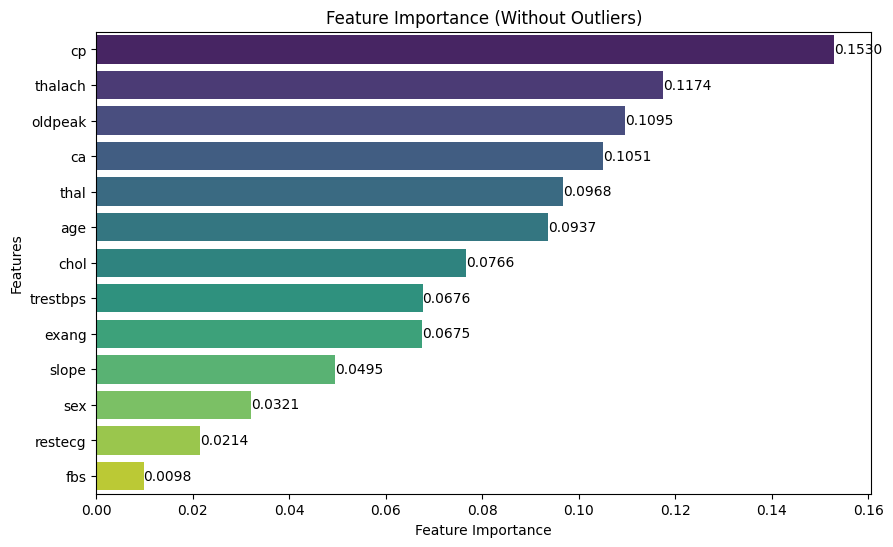

In [55]:
# Feature importance without outliers
plot_feature_importance(X_train_no_outliers, y_train, "Feature Importance (Without Outliers)")

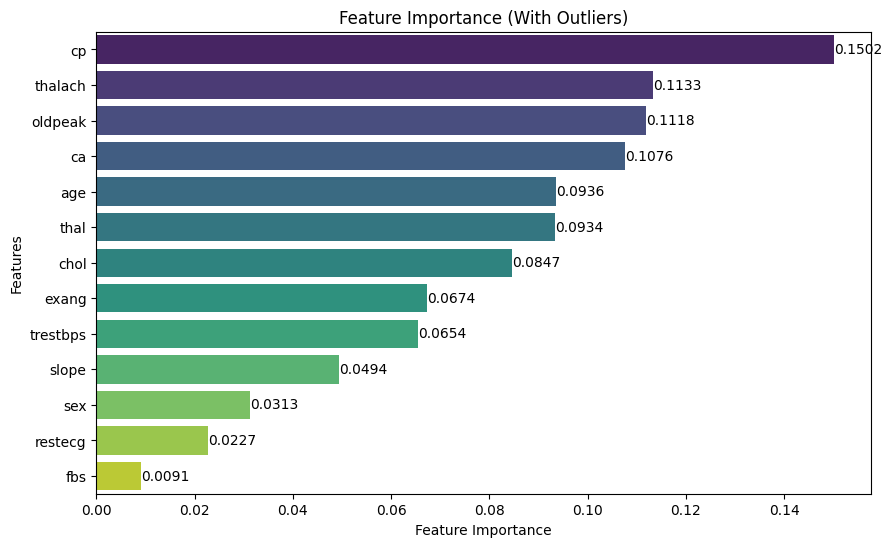

In [56]:
# Feature importance with outliers
plot_feature_importance(X_train_with_outliers, y_train, "Feature Importance (With Outliers)")

# 6.0 Categorical Features Encoding

## One-hot encoding

In [57]:
def encode_categorical(train, val, test, categorical_columns, encoding_type="one-hot", category_orders=None, save_path=None):
    """
    Encodes categorical columns using one-hot or ordinal encoding.

    Parameters:
        - train, val, test: DataFrames to be encoded.
        - categorical_columns: List of categorical columns to encode.
        - encoding_type: "one-hot" or "ordinal" for encoding type.
        - category_orders: Dictionary of category orders for ordinal encoding.
                           Example: {"education": ["High School", "Bachelor", "Master", "PhD"]}

    Returns:
        Encoded train, val, test DataFrames and encoded features DataFrames.
    """
    # Encoder Initialization
    if encoding_type == "one-hot":
        encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    elif encoding_type == "ordinal":
        if category_orders:
            categories = category_orders
        else:
            categories = "auto"  # Default to automatic order if no category_orders provided

        encoder = OrdinalEncoder(categories=categories, handle_unknown="use_encoded_value", unknown_value=-1)
    else:
        raise ValueError("Invalid encoding type. Choose 'one-hot' or 'ordinal'.")

    # Fit encoder on training data
    encoder.fit(train[categorical_columns])

    if save_path:
        joblib.dump(encoder, save_path)
    else:
        joblib.dump(encoder, f"{encoding_type}_encoder.pkl")


    # Transform datasets
    train_encoded = encoder.transform(train[categorical_columns])
    val_encoded = encoder.transform(val[categorical_columns])
    test_encoded = encoder.transform(test[categorical_columns])

    # Get appropriate column names
    if encoding_type == "one-hot":
        column_names = encoder.get_feature_names_out(categorical_columns)
    else:
        column_names = [f"{col}_encoded" for col in categorical_columns]

    # Convert encoded data to DataFrame with original indices
    train_encoded_df = pd.DataFrame(train_encoded, columns=column_names, index=train.index)
    val_encoded_df = pd.DataFrame(val_encoded, columns=column_names, index=val.index)
    test_encoded_df = pd.DataFrame(test_encoded, columns=column_names, index=test.index)

    # Drop original categorical columns before concatenation
    train = train.drop(columns=categorical_columns)
    val = val.drop(columns=categorical_columns)
    test = test.drop(columns=categorical_columns)

    # Concatenate the encoded data with the original data
    train = pd.concat([train, train_encoded_df], axis=1)
    val = pd.concat([val, val_encoded_df], axis=1)
    test = pd.concat([test, test_encoded_df], axis=1)

    return train, val, test, train_encoded_df, val_encoded_df, test_encoded_df

In [58]:
# Apply one-hot encoding to feature datasets (X) (exclude ca & slope)
one_hot_categorical = [x for x in categorical_cols if x not in ['ca', 'slope']]

X_train_with_outliers, X_val_with_outliers, X_test_with_outliers, X_train_with_end, X_val_with_end, X_test_with_end = encode_categorical(
    X_train_with_outliers, X_val_with_outliers, X_test_with_outliers, one_hot_categorical, "one-hot", save_path="onehot_encoder_with_outliers.pkl")

X_train_no_outliers, X_val_no_outliers, X_test_no_outliers, X_train_no_end, X_val_no_end, X_test_no_end = encode_categorical(
    X_train_no_outliers, X_val_no_outliers, X_test_no_outliers, one_hot_categorical, "one-hot", save_path="onehot_encoder_no_outliers.pkl")

In [59]:
def verify_encoded_columns(df_no_end, df_no_outliers, df_with_end, df_with_outliers, df_name):
    """
    Displays a sample of encoded columns from training data before and after handling outliers.

    Parameters:
    df_no_end (pd.DataFrame): Dataset without encoding.
    df_no_outliers (pd.DataFrame): Dataset without outliers.
    df_with_end (pd.DataFrame): Dataset data with encoding.
    df_with_outliers (pd.DataFrame): Dataset data with outliers.
    n_rows (int): Number of rows to display for each DataFrame. Default is 3.
    """

    print(f"Encoded Columns in {df_name} (Without outliers):")
    print(df_no_end.head(3))
    print()
    print(f"The First Row in the {df_name} (Without outliers):")
    print(df_no_outliers.head(1))
    print("-" * 100)
    print(f"Encoded Columns in {df_name} (With outliers):")
    print(df_with_end.head(3))
    print()
    print(f"The First Row in the {df_name} (With outliers):")
    print(df_with_outliers.head(1))

In [60]:
verify_encoded_columns(X_train_no_end, X_train_no_outliers, X_train_with_end, X_train_with_outliers, "Training data")

Encoded Columns in Training data (Without outliers):
   sex_0  sex_1  cp_0  cp_1  cp_2  cp_3  fbs_0.0  fbs_1.0  restecg_0.0  \
0    0.0    1.0   0.0   0.0   1.0   0.0      1.0      0.0          0.0   
1    0.0    1.0   0.0   0.0   1.0   0.0      1.0      0.0          0.0   
2    0.0    1.0   0.0   0.0   1.0   0.0      1.0      0.0          1.0   

   restecg_1.0  restecg_2.0  exang_0  exang_1  thal_0  thal_1  thal_2  thal_3  
0          1.0          0.0      1.0      0.0     0.0     0.0     0.0     1.0  
1          1.0          0.0      0.0      1.0     0.0     0.0     1.0     0.0  
2          0.0          0.0      1.0      0.0     0.0     0.0     0.0     1.0  

The First Row in the Training data (Without outliers):
       age  trestbps      chol  thalach   oldpeak  slope  ca  sex_0  sex_1  \
0  0.90265 -0.134087 -0.319793  1.49743  0.680338      1   3    0.0    1.0   

   cp_0  ...  fbs_1.0  restecg_0.0  restecg_1.0  restecg_2.0  exang_0  \
0   0.0  ...      0.0          0.0          

In [61]:
verify_encoded_columns(X_val_no_end, X_val_no_outliers, X_val_with_end, X_val_with_outliers, "Validation data")

Encoded Columns in Validation data (Without outliers):
   sex_0  sex_1  cp_0  cp_1  cp_2  cp_3  fbs_0.0  fbs_1.0  restecg_0.0  \
0    0.0    1.0   0.0   0.0   1.0   0.0      1.0      0.0          0.0   
1    1.0    0.0   0.0   1.0   0.0   0.0      1.0      0.0          0.0   
2    0.0    1.0   0.0   1.0   0.0   0.0      1.0      0.0          0.0   

   restecg_1.0  restecg_2.0  exang_0  exang_1  thal_0  thal_1  thal_2  thal_3  
0          1.0          0.0      1.0      0.0     0.0     0.0     1.0     0.0  
1          1.0          0.0      1.0      0.0     0.0     0.0     1.0     0.0  
2          1.0          0.0      1.0      0.0     0.0     0.0     0.0     1.0  

The First Row in the Validation data (Without outliers):
        age  trestbps      chol   thalach   oldpeak  slope  ca  sex_0  sex_1  \
0 -0.413337 -1.415722 -1.595497 -1.250991 -0.403616      2   0    0.0    1.0   

   cp_0  ...  fbs_1.0  restecg_0.0  restecg_1.0  restecg_2.0  exang_0  \
0   0.0  ...      0.0          0.0  

In [62]:
verify_encoded_columns(X_test_no_end, X_test_no_outliers, X_test_with_end, X_test_with_outliers, "Testing data")

Encoded Columns in Testing data (Without outliers):
     sex_0  sex_1  cp_0  cp_1  cp_2  cp_3  fbs_0.0  fbs_1.0  restecg_0.0  \
678    0.0    1.0   0.0   0.0   1.0   0.0      0.0      1.0          1.0   
543    0.0    1.0   0.0   1.0   0.0   0.0      1.0      0.0          0.0   
323    1.0    0.0   0.0   1.0   0.0   0.0      1.0      0.0          1.0   

     restecg_1.0  restecg_2.0  exang_0  exang_1  thal_0  thal_1  thal_2  \
678          0.0          0.0      0.0      1.0     0.0     0.0     0.0   
543          1.0          0.0      1.0      0.0     0.0     0.0     0.0   
323          0.0          0.0      1.0      0.0     0.0     0.0     1.0   

     thal_3  
678     1.0  
543     1.0  
323     0.0  

The First Row in the Testing data (Without outliers):
          age  trestbps      chol   thalach   oldpeak  slope  ca  sex_0  \
678  1.503672  2.108774  0.659766  0.006761  0.499679      1   0    0.0   

     sex_1  cp_0  ...  fbs_1.0  restecg_0.0  restecg_1.0  restecg_2.0  \
678    

## Ordinal Encoding

In [63]:
# Apply ordinal encoding to feature datasets (X) (ca & slope)
ordinal_features = ['ca', 'slope']
ordinal_orders = [
    ['0', '1', '2', '3', '4'],
    ['0', '1', '2']
]

X_train_with_outliers, X_val_with_outliers, X_test_with_outliers, X_train_with_end, X_val_with_end, X_test_with_end = encode_categorical(
    X_train_with_outliers, X_val_with_outliers, X_test_with_outliers, ordinal_features, "ordinal", ordinal_orders, save_path="ordinal_encoder_with_outliers.pkl")

X_train_no_outliers, X_val_no_outliers, X_test_no_outliers, X_train_no_end, X_val_no_end, X_test_no_end = encode_categorical(
    X_train_no_outliers, X_val_no_outliers, X_test_no_outliers, ordinal_features, "ordinal", ordinal_orders, save_path="ordinal_encoder_no_outliers.pkl")

In [64]:
verify_encoded_columns(X_train_no_end, X_train_no_outliers, X_train_with_end, X_train_with_outliers, "Training data")

Encoded Columns in Training data (Without outliers):
   ca_encoded  slope_encoded
0         3.0            1.0
1         0.0            2.0
2         0.0            1.0

The First Row in the Training data (Without outliers):
       age  trestbps      chol  thalach   oldpeak  sex_0  sex_1  cp_0  cp_1  \
0  0.90265 -0.134087 -0.319793  1.49743  0.680338    0.0    1.0   0.0   0.0   

   cp_2  ...  restecg_1.0  restecg_2.0  exang_0  exang_1  thal_0  thal_1  \
0   1.0  ...          1.0          0.0      1.0      0.0     0.0     0.0   

   thal_2  thal_3  ca_encoded  slope_encoded  
0     0.0     1.0         3.0            1.0  

[1 rows x 24 columns]
----------------------------------------------------------------------------------------------------
Encoded Columns in Training data (With outliers):
   ca_encoded  slope_encoded
0         3.0            1.0
1         0.0            2.0
2         0.0            1.0

The First Row in the Training data (With outliers):
        age  trestbps     

In [65]:
verify_encoded_columns(X_val_no_end, X_val_no_outliers, X_val_with_end, X_val_with_outliers, "Validation data")

Encoded Columns in Validation data (Without outliers):
   ca_encoded  slope_encoded
0         0.0            2.0
1         0.0            2.0
2         0.0            2.0

The First Row in the Validation data (Without outliers):
        age  trestbps      chol   thalach   oldpeak  sex_0  sex_1  cp_0  cp_1  \
0 -0.413337 -1.415722 -1.595497 -1.250991 -0.403616    0.0    1.0   0.0   0.0   

   cp_2  ...  restecg_1.0  restecg_2.0  exang_0  exang_1  thal_0  thal_1  \
0   1.0  ...          1.0          0.0      1.0      0.0     0.0     0.0   

   thal_2  thal_3  ca_encoded  slope_encoded  
0     1.0     0.0         0.0            2.0  

[1 rows x 24 columns]
----------------------------------------------------------------------------------------------------
Encoded Columns in Validation data (With outliers):
   ca_encoded  slope_encoded
0         0.0            2.0
1         0.0            2.0
2         0.0            2.0

The First Row in the Validation data (With outliers):
        age  t

In [66]:
verify_encoded_columns(X_test_no_end, X_test_no_outliers, X_test_with_end, X_test_with_outliers, "Testing data")

Encoded Columns in Testing data (Without outliers):
     ca_encoded  slope_encoded
678         0.0            1.0
543         0.0            0.0
323         0.0            1.0

The First Row in the Testing data (Without outliers):
          age  trestbps      chol   thalach   oldpeak  sex_0  sex_1  cp_0  \
678  1.503672  2.108774  0.659766  0.006761  0.499679    0.0    1.0   0.0   

     cp_1  cp_2  ...  restecg_1.0  restecg_2.0  exang_0  exang_1  thal_0  \
678   0.0   1.0  ...          0.0          0.0      0.0      1.0     0.0   

     thal_1  thal_2  thal_3  ca_encoded  slope_encoded  
678     0.0     0.0     1.0         0.0            1.0  

[1 rows x 24 columns]
----------------------------------------------------------------------------------------------------
Encoded Columns in Testing data (With outliers):
     ca_encoded  slope_encoded
678         0.0            1.0
543         0.0            0.0
323         0.0            1.0

The First Row in the Testing data (With outliers)

In [67]:
# Save into csv file

# Save feature datasets (X)
X_train_with_outliers.to_csv("X_train_with_outliers.csv", index=False)
X_val_with_outliers.to_csv("X_val_with_outliers.csv", index=False)
X_test_with_outliers.to_csv("X_test_with_outliers.csv", index=False)

X_train_no_outliers.to_csv("X_train_no_outliers.csv", index=False)
X_val_no_outliers.to_csv("X_val_no_outliers.csv", index=False)
X_test_no_outliers.to_csv("X_test_no_outliers.csv", index=False)

# Save target datasets (y)
y_train.to_csv("y_train.csv", index=False)
y_val.to_csv("y_val.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

print("All datasets have been saved as CSV files.")

All datasets have been saved as CSV files.
